In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import trapz  # Trapezoidal rule for integration


In [3]:
# H0 time independent Hamiltonian
# Hint interaction part of the Hamiltonian
# omega drive frequency
# nph number of photons (should be odd)
# measvec compute overlap of state with this vector
# H = H0 + Hint*cos(omega*t)


# where H0=0.5*Delta*sigma_z + epsilon*sigma_x
# # and Hint=0.5*Vstr*sigma_z

# Define the absorption as the probability of measuring in the state measvec
measvec = np.array([1,0])
# Hamiltonian parameters
epsilon = 0.2
# range of delta to consider
Deltas = np.linspace(-6,6,600)
# Drive frequency
omega = 1.5
#%number of photon manifolds (should be odd)
n_ph = 13
#number of different drive strengths to consider
Vs = [0.05,0.2,1]

#define sigma_x and sigma_z
sigma_x = sigmax()
sigma_z = sigmaz()




In [4]:
Delta = 6
V = 1
epsilon = 0.2
omega = 1.5
T = 2*np.pi / omega
tlist  = np.linspace(0.0, 10 * T, 101)
# Define the initial state
psi_0 = basis(2,0)
# Define the Hamiltonian parameters
H0 = Delta/2*sigma_z + epsilon*sigma_x

Hint = V * sigma_z / 2
# H = H0 + Hint*cos(omega*t
# Define the time-dependent Hamiltonian
# H = [H0, [Hint, 'cos(omega*t)']]

args = {'w': omega}

H = [H0, [Hint, lambda t, w: np.cos(w * t)]]

psi_0 

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

#Method 1: To estimate Absorption Probability

In [5]:
H0 = Delta/2*sigma_z + epsilon*sigma_x

gs = H0.eigenstates()[1][0]
gs_val = H0.eigenstates()[0][0]

es = H0.eigenstates()[1][1]
es_val = H0.eigenstates()[0][1]



# find the floquet modes for the time-dependent hamiltonian
floquetbasis = FloquetBasis(H, T, args)

# decompose the inital state in the floquet modes
f_coeff = floquetbasis.to_floquet_basis(psi_0)

# es = floquetbasis.mode(0.1)[1]

H0.eigenstates() 

(array([-3.00665928,  3.00665928]),
 array([Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.03327794]
         [-0.99944614]]                                                       ,
        Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.99944614]
         [-0.03327794]]                                                       ],
       dtype=object))

In [6]:
# write a function to calculate the probability of measuring the state in a certain state
def trans_probab(floquetbasis, measvec, t):
    """
    Calculate the probability of measuring the state in the given measurement vector.
    
    Parameters:
        t: time
        measvec (array): the measurement vector
        
    Returns:
        prob (float): probability of measuring in the given state
    """

    # # find the floquet modes for the time-dependent hamiltonian
    # floquetbasis = FloquetBasis(H, T, args)
    # decompose the inital state in the floquet modes
    state  = floquetbasis.from_floquet_basis(f_coeff, t)

    # Calculate the inner product and square its magnitude
    # measvec = floquetbasis.mode(t)[1]

    prob = np.abs(state.dag() * measvec)**2
    overlap = state.overlap(measvec)
    prob_1 = abs(overlap)**2
    return prob_1

def time_avg_probab(floquetbasis, measvec, T, num_points=1000):
    """
    Compute the time-averaged transition probability over time period T.

    Parameters:
        trans_probab (callable): Function trans_probab(t, measvec) -> P_{g→e}(t).
        measvec (Qobj): Measurement state (e.g., |e⟩).
        T (float): Total time period.
        num_points (int): Number of time steps for numerical integration.

    Returns:
        float: Time-averaged probability (1/T) ∫₀ᵀ P_{g→e}(t) dt.
    """
    tlist = np.linspace(0, T, num_points)  # Time grid
    prob_list = [trans_probab(floquetbasis, measvec, t) for t in tlist]  # P_{g→e}(t) at each t

    # Integrate using trapezoidal rule and normalize by T
    avg_prob = trapz(prob_list, tlist) / T
    return avg_prob

# time_avg_probab(es, floquetbasis, T, num_points=1000)

trans_probab(floquetbasis, es, 100)

time_avg_probab(floquetbasis, gs, T, num_points=100)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12956\564015736.py:44: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  avg_prob = trapz(prob_list, tlist) / T


0.0008167702699488046

100%|██████████| 1000/1000 [00:00<00:00, 2720.95it/s]


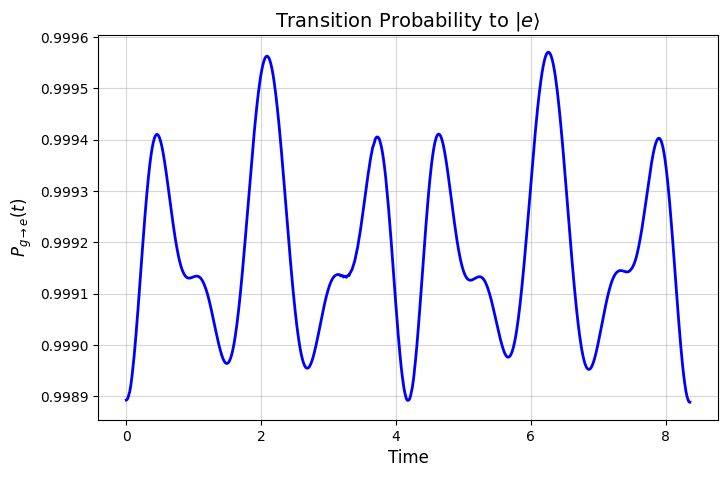

0.9995703283156582

In [7]:
# plot the probability of measuring in the state measvec for different times
tlist = np.linspace(0, 8.36, 1000)
probs = []

for t in tqdm(tlist):
    probs.append(trans_probab(floquetbasis, es, t))
    # print(trans_probab(floquetbasis, es, t) + trans_probab(floquetbasis, gs, t))
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(tlist, probs, 'b-', linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel(r'$P_{g \to e}(t)$', fontsize=12)
plt.title('Transition Probability to $|e\\rangle$', fontsize=14)

plt.grid(alpha=0.5)
plt.show()
max(probs)

In [18]:
Deltas = np.linspace(-6,6,600)
# Drive frequency
omega = 1.5
#number of different drive strengths to consider
Vs = [0.05,0.2,1]

# Initialize results storage
results = np.zeros((len(Vs), len(Deltas)))
gs_vals = []
es_vals = []
epsilon = 0.2

for iD,Delta in enumerate(tqdm(Deltas)):

    H0 = (Delta / 2) * sigma_z + epsilon * sigma_x
    evals = H0.eigenenergies()       
    gs_vals.append(evals[0])  # ground state energy
    es_vals.append(evals[1])
    for iV,V in enumerate(Vs):
        Hint = V * sigma_z / 2
        # H = H0 + Hint*cos(omega*t)
        # Define the time-dependent Hamiltonian
        # H = [H0, [Hint, 'cos(omega*t)']]
        args = {'w': omega}
        # print(evals)
        H = [H0, [Hint, lambda t, w: np.cos(w * t)]]

        # find the floquet modes for the time-dependent hamiltonian
        floquetbasis = FloquetBasis(H, T, args)

        t_avg_probab = time_avg_probab(floquetbasis, es, T)
        # Time-averaged probability
        results[iV, iD] = t_avg_probab

  0%|          | 0/600 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_12956\564015736.py:44: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  avg_prob = trapz(prob_list, tlist) / T
100%|██████████| 600/600 [06:51<00:00,  1.46it/s]


<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12956\2913573407.py:29: SyntaxWarning: invalid escape sequence '\d'
  axs[1].set_title("Transition Probability vs. $\delta/\omega$", fontsize=14)


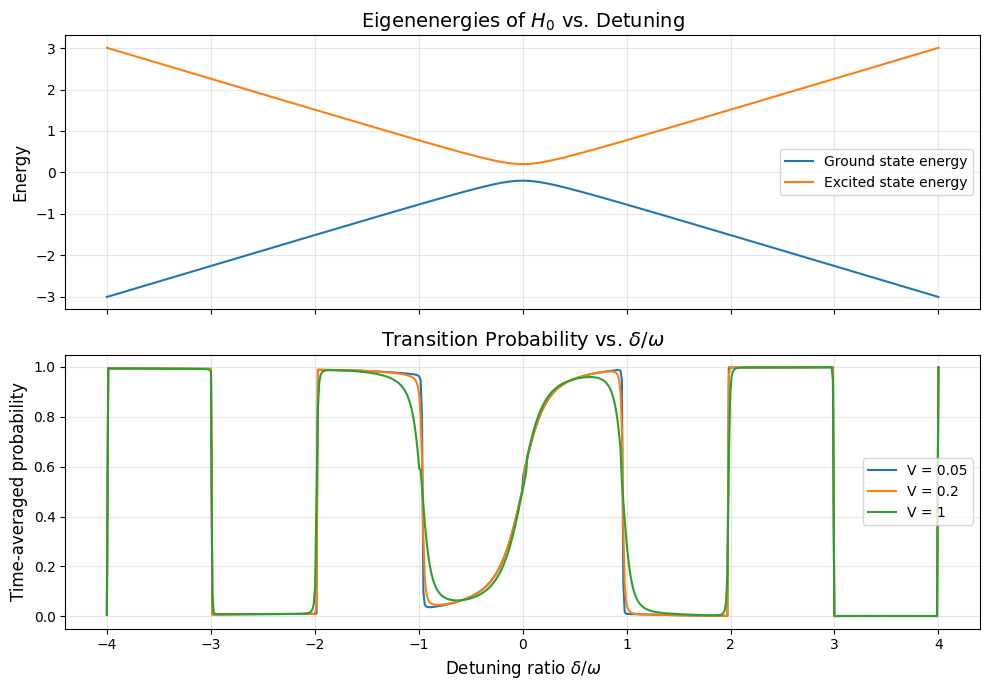

In [21]:
# # Plot results
# plt.figure(figsize=(10, 3))
# for iV, V in enumerate(Vs):
#     plt.plot(Deltas / omega, results[iV], label=f"V = {V}")
#     plt.plot(Deltas / omega, gs_vals, label="Ground state energy")
#     plt.plot(Deltas / omega, es_vals, label="Excited state energy")
# plt.xlabel(r"Detuning ratio $\delta/\omega$", fontsize=12)
# plt.ylabel("Time-averaged probability", fontsize=12)
# plt.title("Transition Probability vs. $\delta/\omega$", fontsize=14)
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()# ...existing code...

fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# --- Upper plot: Eigenenergies ---
axs[0].plot(Deltas / omega, gs_vals, label="Ground state energy")
axs[0].plot(Deltas / omega, es_vals, label="Excited state energy")
axs[0].set_ylabel("Energy", fontsize=12)
axs[0].set_title("Eigenenergies of $H_0$ vs. Detuning", fontsize=14)
axs[0].legend()
axs[0].grid(alpha=0.3)

# --- Lower plot: Transition probabilities ---
for iV, V in enumerate(Vs):
    axs[1].plot(Deltas / omega, results[iV], label=f"V = {V}")
axs[1].set_xlabel(r"Detuning ratio $\delta/\omega$", fontsize=12)
axs[1].set_ylabel("Time-averaged probability", fontsize=12)
axs[1].set_title("Transition Probability vs. $\delta/\omega$", fontsize=14)
axs[1].legend()
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
# ...existing code...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Qubit parameters
omega_0 = 2 * np.pi * 1.0  # qubit frequency (1 GHz)
omega_drive = 2 * np.pi * 1.0  # drive frequency = 1 GHz
drive_amplitude = 0.2 * 2 * np.pi  # Rabi drive amplitude

# Operators
sm = destroy(2)  # lowering operator
sx = sigmax()
sy = sigmay()
sz = sigmaz()

# Time-dependent Hamiltonian: H(t) = ω₀/2 σz + drive * cos(ωd t) * σx
def H_t(t, args):
    return 0.5 * omega_0 * sz + drive_amplitude * np.cos(omega_drive * t) * sx

# Initial state: excited state
psi0 = basis(2, 1)

# Spectral density function for amplitude damping
gamma = 0.05  # decay rate
def noise_spectrum(omega):
    return (omega > 0) * gamma

# Time list
T = 2 * np.pi / omega_drive  # drive period
tlist = np.linspace(0, 10*T, 500)  # simulate for 10 periods

# Solve using fmmesolve
result = fmmesolve(H_t, psi0, tlist, [sm], [noise_spectrum])

# Plot the excited state population ⟨1|ρ(t)|1⟩
excited_population = expect(basis(2,1)*basis(2,1).dag(), result.states)

plt.figure(figsize=(8,5))
plt.plot(tlist, excited_population, label="Excited state population")
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Qubit with Amplitude Damping and Periodic Drive (Floquet-Markov)')
plt.grid(True)
plt.legend()
plt.show()


TypeError: noise_spectrum() takes 1 positional argument but 2 were given